# Vacant Properties in Pittsburgh

(Data from [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/city-owned-properties))

This notebook will discuss an important topic when deciding the best neighborhood in Pittsburgh: **which neighborhood has the fewest abandoned buildings?**

While data on total 'abandoned buildings' is hard to come by, we have a data set for all **city-owned properties** in Pittsburgh, including many vacant ones. Let's check it out.

## Looking at our data

In [12]:
# import pandas
import pandas as pd
import matplotlib.pyplot as plt

# turn csv into data frame
props = pd.read_csv("city-owned-properties.csv",index_col="_id") # use the column named _id as the row index

# check some random values in the dataframe
props.sample(5)

,id,pin,address,owner,parc_sq_ft,class,zoned_as,inventory_type,current_status,acquisition_method,...,longitude,census_tract,neighborhood_name,council_district,ward,fire_zone,police_zone,dpw_streets,dpw_enviro,dpw_parks
_id,,,,,,,,,,,,,,,,,,,,,
1350262,183314,0027B00306000000,3002 CAMPT ST,City of Pittsburgh,792.0,Vacant Land,R2-L,Hold For Study,Hold for Study,Treasurer Sale,...,-79.959415,4.200305e+10,Upper Hill,6.0,5.0,2-22,2.0,3.0,Central,Schenley
1352133,179793,0231K00199000000,8402 BRICELYN ST,City of Pittsburgh,2500.0,Vacant Land,R2-L,Public Sale,Available for Sale,Treasurer Sale,...,-79.876759,4.200313e+10,East Hills,9.0,13.0,3-17,5.0,2.0,Eastern,Frick
1354623,173672,0023D00378000000,1543 I-279,City of Pittsburgh,1628.0,Vacant Land,H,Hold For Study,Hold for Study,Treasurer Sale,...,-79.999695,4.200326e+10,Spring Hill-City View,1.0,24.0,1-24,1.0,1.0,Northern,Riverview
1354700,183015,0024B00212000000,1022 ITIN ST,City of Pittsburgh,2890.0,Vacant Land,H,Hold For Study,Hold for Study,Treasurer Sale,...,-79.994432,4.200356e+10,East Allegheny,1.0,24.0,1-5,1.0,1.0,Northern,Riverview
1350159,185277,0010L00336000000,2506 HALLETT ST,City of Pittsburgh,2400.0,Vacant Land,RM-M,CDC Property Reserve,Sale Pending,Treasurer Sale,...,-79.970300,4.200305e+10,Middle Hill,6.0,5.0,2-5,2.0,3.0,Central,Schenley


Above is a brief sample of some of the data. **That's a lot of information.** Just for fun, let's see what the biggest property is:

In [3]:
props['parc_sq_ft'].max()

18164520.0

## Narrowing it down

Some googling reveals that the property mentioned above, the largest in the dataset (by area) is actually **Schenley Park.**

Let's make sure we only count land that isn't used for a good purpose. This next section of code will include only parcels of land in the category **"vacant land"** and exclude parks.

In [4]:
# query mask: vacant land (and not a park)
vacant = (props['inventory_type'] != "Park") & (props['class'] == "Vacant Land")
vacants = props[vacant]
vacants['neighborhood_name'].value_counts()

Hazelwood                810
Perry South              788
Larimer                  518
Homewood North           487
Garfield                 376
                        ... 
Central Lawrenceville      4
Glen Hazel                 3
Allegheny West             2
Friendship                 1
Arlington Heights          1
Name: neighborhood_name, Length: 89, dtype: int64

That was the **total quantity** of properties. However, we have the area, so let's take sums of areas instead of counting (because a larger abandoned building or plot of land should hold more weight than a small one).

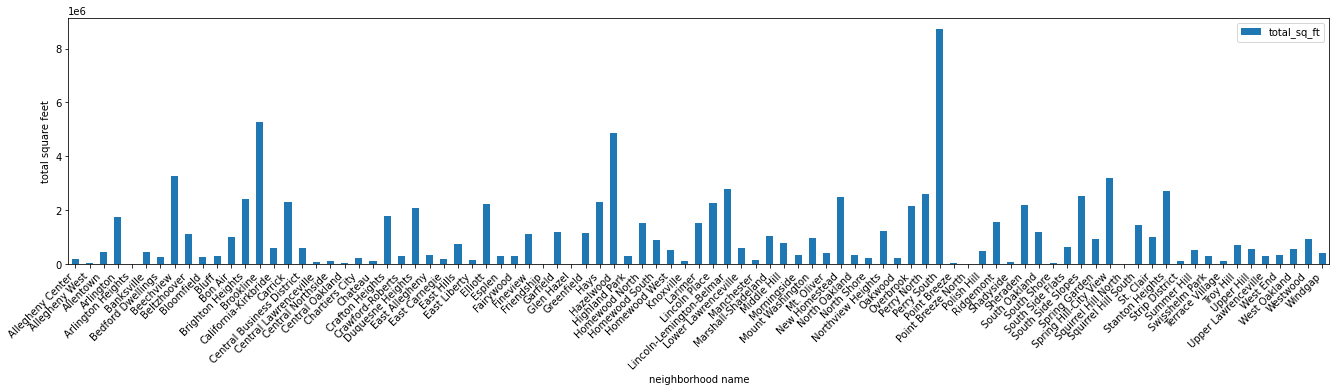

In [8]:
# a new dataframe with only the vacant land included
areas = vacants.groupby('neighborhood_name')['parc_sq_ft'].sum().reset_index()
areas.rename(columns={'parc_sq_ft': 'total_sq_ft'}, inplace=True)
areas.set_index('neighborhood_name', inplace=True)

# create the graph
areas.plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.xlabel('neighborhood name')
plt.ylabel('total square feet')
plt.show()

That list is in alphabetical order. Let's try ordering it by total area.

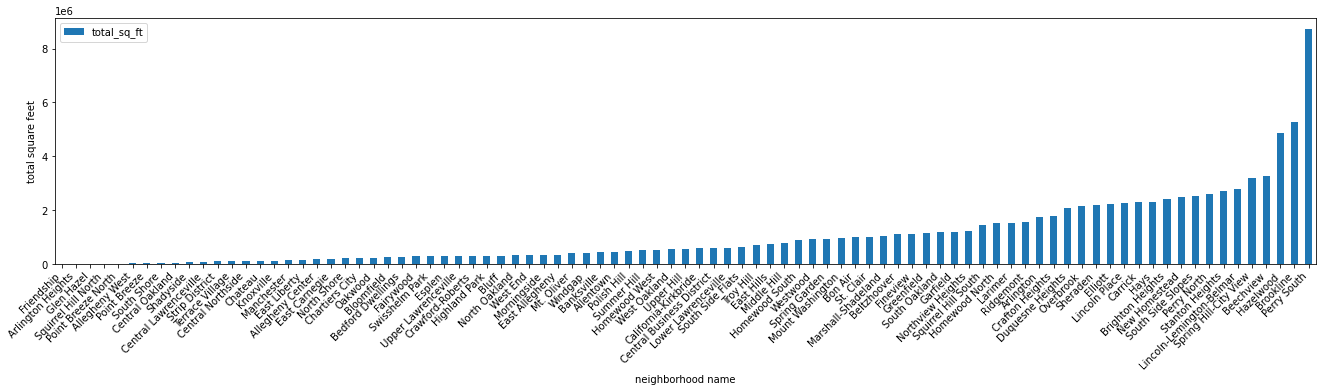

In [9]:
# sort everything by area
areas.sort_values(by='total_sq_ft', inplace=True)

# create the graph
areas.plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.xlabel('neighborhood name')
plt.ylabel('total square feet')
plt.show()

## Scoring neighborhoods
The data looks like it loosely follows a log scale. In order to assign each neighborhood a score (out of 10), let's find some arbitrary **calculations** including a **log operation** that bound all neighborhoods between 0 and 10. Everything will need to be made **negative** to make sure that more vacant land correlates with a lower score.

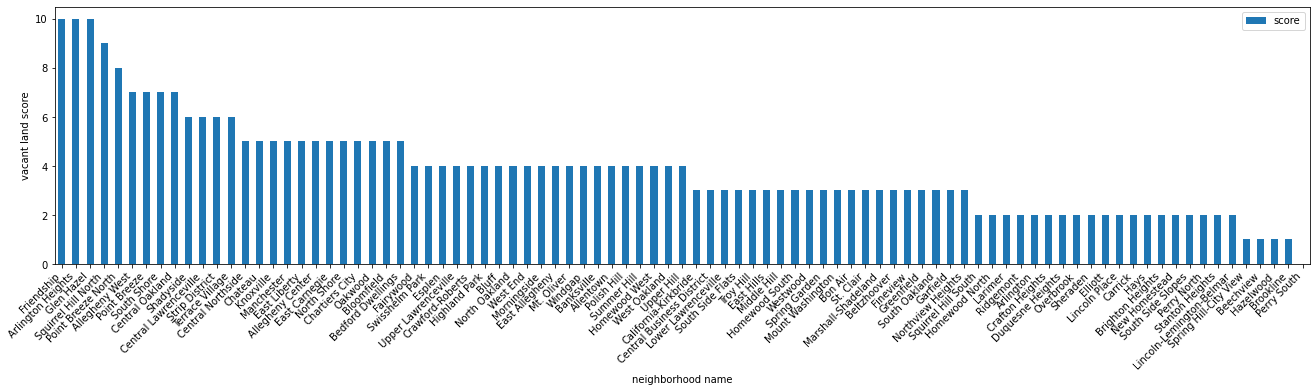

In [10]:
import math

scores = pd.DataFrame(index=areas.index) # the new dataframe

for idx in scores.index:
    # the line below calculates the score using log base 10
    score = -1 * round(((math.log(areas.loc[idx, 'total_sq_ft'],10) - 4.75)*2.95)-6.5)
    scores.loc[idx, 'score'] = score

# once again, create the graph
scores.plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.xlabel('neighborhood name')
plt.ylabel('vacant land score')
plt.show()

#### This graph shows every neighborhood with its vacant land score.

And there you have it! Our biggest winners are **Friendship**, **Arlington Heights**, and **Glen Hazel**, but many others are not far behind. Faring the worst is Perry South (achieving the only score of 0), but I'm sure the neighborhood has other redeeming qualities.